# Wake Models

A wake model in FLORIS is made up of four components that together constitute a wake.
At minimum, the velocity deficit profile behind a wind turbine is required. For most models,
an additional wake deflection model is included to model the effect of yaw misalignment.
Turbulence models are also available to couple with the deficit and deflection components.
Finally, methods for combining wakes with the rest of the flow field are available.

Computationally, the solver algorithm and grid-type supported by each wake model can also
be considered as part of the model itself. As shown in the diagram below, the mathematical
formulations can be considered as the main components of the model. These are typically
associated directly to each other and in some cases they are bundled together into
a single mathematical formulation. The solver algorithm and grid type are associated
to the math formulation, but they are typically more generic.

```{mermaid}
flowchart LR
    A["Deficit"]
    B["Deflection"]
    C["Turbulence"]
    D["Velocity"]
    E["Solver"]
    F["Grid"]

    subgraph H[FLORIS Wake Model]
        direction LR
        subgraph G[Math Model]
            direction LR
            A---B
            B---C
            C---D
        end
        G---E
        E---F
    end
```

The models in FLORIS are typically developed as a combination of velocity deficit and wake
deflection models, and some also have custom turbulence and combination models. The descriptions
below use the typical combinations except where indicated. The specific settings can be seen
in the corresponding input files found in the source code dropdowns.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from floris.tools import FlorisInterface
import floris.tools.visualization as wakeviz

NREL5MW_D = 126.0

def model_plot(inputfile):
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    fi = FlorisInterface(inputfile)
    fi.reinitialize(layout_x=np.array([0.0, 2*NREL5MW_D]), layout_y=np.array([0.0, 2*NREL5MW_D]))
    yaw_angles = np.zeros((1, 2))
    yaw_angles[:,0] = 20.0
    horizontal_plane = fi.calculate_horizontal_plane(
        height=90.0,
        yaw_angles=yaw_angles
    )
    wakeviz.visualize_cut_plane(horizontal_plane, ax=axes)
    wakeviz.plot_turbines_with_fi(fi, ax=axes, yaw_angles=yaw_angles)

## Jensen and Jimenez

The Jensen model computes the wake velocity deficit based on the classic Jensen/Park model
{cite:t}`jensen1983note`. It is often refered to as a "top-hat" model because the spanwise
velocity profile is constant across the wake and abruptly jumps to freestream outside of the
wake boundary line. The slope of the wake boundary line, or wake expansion, is a user parameter.

The Jiménez wake deflection model is derived from {cite:t}`jimenez2010application`.

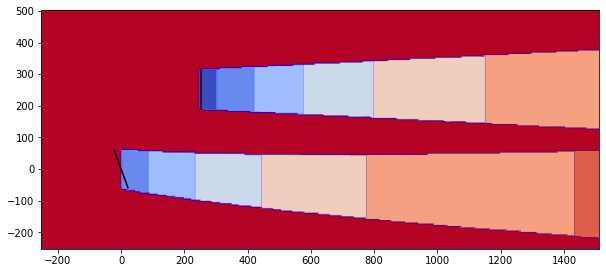

In [2]:
model_plot("../examples/inputs/jensen.yaml")

## Gauss and GCH

The Gaussian velocity model is implemented based on {cite:t}`bastankhah2016experimental` and
{cite:t}`niayifar2016analytical`. This model represents the velocity deficity as a gaussian
distribution in the spanwise direction, and the gaussian profile is controlled by user parameters.
There is a near wake zone and a far wake zone. Both maintain the gaussian profile in the spanwise
direction, but they have different models for wake recovery.

The Gauss deflection model is a blend of the models described in
{cite:t}`bastankhah2016experimental` and {cite:t}`King2019Controls` for calculating
the deflection field in turbine wakes.

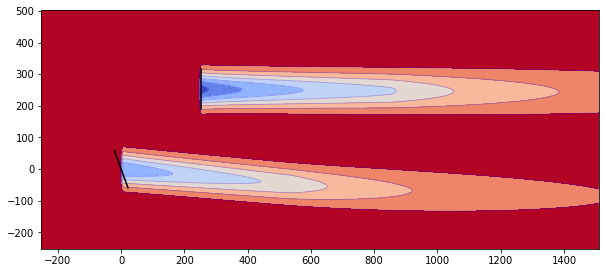

In [3]:
model_plot("../examples/inputs/gch.yaml")

## Empirical Gaussian

FLORIS's "empirical" model has the same Gaussian wake shape as other popular FLORIS models.
However, the models that describe the wake width and deflection have been reorganized to provide
simpler tuning and data fitting.

For more information, see {ref}`empirical_gauss_model`

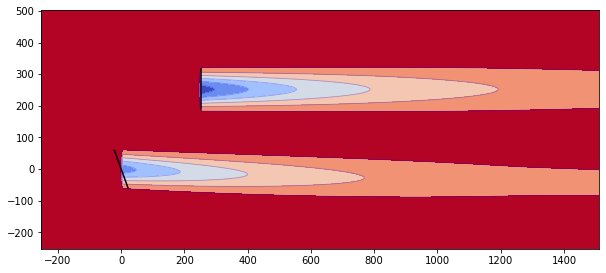

In [4]:
model_plot("../examples/inputs/emgauss.yaml")

## Cumulative Curl
The cumulative curl model is an implementation of the model described in {cite:t}`bay_2022`,
which itself is based on the cumulative model of {cite:t}`bastankhah_2021`

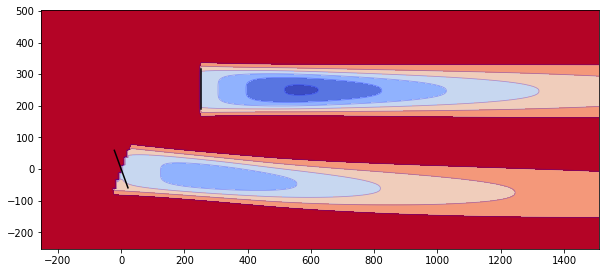

In [5]:
model_plot("../examples/inputs/cc.yaml")

## TurbOPark

TurbOPark is a velocity deficit model. For model details see the following references:

- https://github.com/OrstedRD/TurbOPark
- https://github.com/OrstedRD/TurbOPark/blob/main/TurbOPark%20description.pdf
- Nygaard, Nicolai Gayle, et al. "Modelling cluster wakes and wind farm blockage." 2020

## Turbulence Models

### Crespo-Hernandez

CrespoHernandez is a wake-turbulence model that is used to compute additional variability introduced
to the flow field by operation of a wind turbine. Implementation of the model follows the original
formulation and limitations outlined in {cite:t}`crespo1996turbulence`.

## Wake Combination Models

The wakes throughout the flow field need to be combined in a careful manner in order to
accurately capture their coupled effects. A simple model is to simple add them,
but this can result in negative velocities a few turbines into the farm. More careful
methods are available within FLORIS and shown here.

Each model is described below and its effects are plotted with two turbines in a line.
These descriptions use the Jensen and Jimenez models since they highlight the differences
in the combination models themselves.
The upper plots show the turbine wakes individually to give a reference for the uncombined wake.
The lower plots show both turbines along with their wakes combined with the chosen model.

In [6]:
def combination_plot(method: str):
    X_UPSTREAM = 0.0
    X_DOWNSTREAM = 5 * 126.0
    X0_BOUND = -200
    X1_BOUND = 1500

    # Set the combination method
    fi = FlorisInterface("../examples/inputs/jensen.yaml")
    settings = fi.floris.as_dict()
    settings["wake"]["model_strings"]["combination_model"] = method
    fi = FlorisInterface(settings)

    # Plot two turbines individually
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    fi.reinitialize(layout_x=np.array([X_UPSTREAM]), layout_y=np.zeros(1))
    horizontal_plane = fi.calculate_horizontal_plane(
        height=90.0,
        x_bounds=(X0_BOUND, X1_BOUND),
        yaw_angles=np.array([[20.0]])
    )
    wakeviz.visualize_cut_plane(horizontal_plane, ax=axes[0])
    wakeviz.plot_turbines_with_fi(fi, ax=axes[0])
    wakeviz.plot_turbines_with_fi(fi, ax=axes[1])

    fi.reinitialize(layout_x=np.array([X_DOWNSTREAM]), layout_y=np.zeros(1))
    horizontal_plane = fi.calculate_horizontal_plane(
        height=90.0,
        x_bounds=(X0_BOUND, X1_BOUND),
        yaw_angles=np.array([[0.0]])
    )
    wakeviz.visualize_cut_plane(horizontal_plane, ax=axes[1])
    wakeviz.plot_turbines_with_fi(fi, ax=axes[0])
    wakeviz.plot_turbines_with_fi(fi, ax=axes[1])

    # Plot the combination of turbines
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    fi.reinitialize(layout_x=np.array([X_UPSTREAM, X_DOWNSTREAM]), layout_y=np.zeros(2))
    horizontal_plane = fi.calculate_horizontal_plane(
        height=90.0,
        x_bounds=(X0_BOUND, X1_BOUND),
        yaw_angles=np.array([[20.0, 0.0]])
    )
    wakeviz.visualize_cut_plane(horizontal_plane, ax=axes)
    wakeviz.plot_turbines_with_fi(fi, ax=axes)

### Freestream Linear Superposition (FLS)

FLS uses freestream linear superposition to apply the wake velocity deficits to the freestream
flow field.

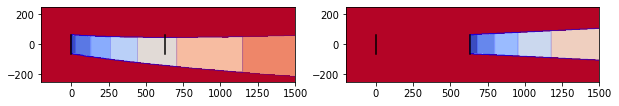

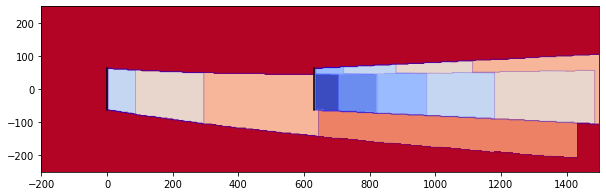

In [7]:
combination_plot("fls")

### Max

The MAX model incorporates the velocity deficits into the base flow field by selecting the
maximum of the two for each point. For more information, refer to {cite:t}`gunn2016limitations`.

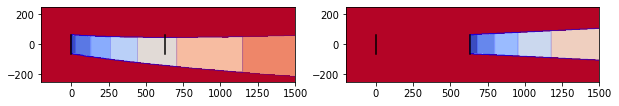

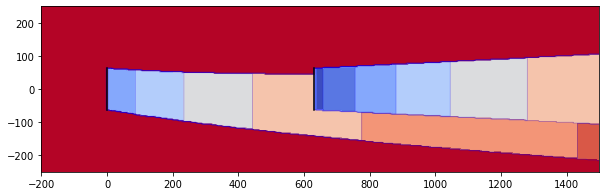

In [8]:
combination_plot("max")

### Sum of Squares Freestream Superposition (SOSFS)

This model combines the wakes via a sum of squares of the new wake to add and the existing
flow field.

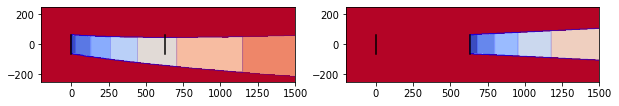

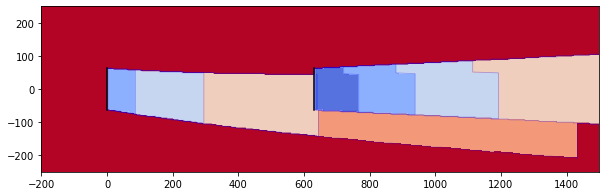

In [9]:
combination_plot("sosfs")